## Stack Exchange Post text classifiction using Fasttext.

**_Authenticating the google colab with Google SDK_**

In [1]:
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

%load_ext google.colab.data_table

Authenticated


**_loading required libraries_**

In [2]:
#Installing library for plotply charts.
!pip install chart_studio

In [3]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import nltk
from nltk.corpus import stopwords
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go
import chart_studio.plotly as py
from plotly import tools

%matplotlib inline
nltk.download("stopwords")
pd.set_option('mode.chained_assignment', None)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


**_Querying Google Cloud Platform_**

_We have connected to Google cloud Platform using a project id (assigned to every user) and then ran a select query with limit to fetch only 500000 records on **stackoverflow_posts** table from the **bigquery public data  stackoverflow database** and created a dataframe._

In [4]:
#Project Id for google cloud platform
project_id = 'commanding-iris-288015'

stack_ex_data = pd.io.gbq.read_gbq('''
  SELECT * FROM `bigquery-public-data.stackoverflow.stackoverflow_posts`
  LIMIT 500000
''', project_id=project_id, dialect='standard')

print("Shape of the Stackexchange dataset:", stack_ex_data.shape)
stack_ex_data.head()

Shape of the Stackexchange dataset: (500000, 20)


,id,title,body,accepted_answer_id,answer_count,comment_count,community_owned_date,creation_date,favorite_count,last_activity_date,last_edit_date,last_editor_display_name,last_editor_user_id,owner_display_name,owner_user_id,parent_id,post_type_id,score,tags,view_count
0,525063,Android Respond To URL in Intent,<p>I want my intent to be launched when the us...,525086.0,1.0,2,NaT,2009-02-08 02:55:56.867000+00:00,65,2016-04-10 03:28:09.653000+00:00,2015-08-15 10:24:12.720000+00:00,None,1529129.0,Isaac Waller,764272.0,NaN,1,132,android|url|android-intent|intentfilter|launch,91060.0
1,14128723,Eclipse -- Progress windows don't show up any ...,<p>I used to see both Building and Cleaning ac...,14128762.0,1.0,0,NaT,2013-01-02 20:31:53.523000+00:00,4,2013-01-02 20:34:55.003000+00:00,NaT,None,NaN,user1499731,NaN,NaN,1,13,java|eclipse,4272.0
2,20728,What's the best way to create ClickOnce deploy...,<p>Our team develops distributed winform apps....,20806.0,2.0,0,NaT,2008-08-21 18:35:04.410000+00:00,5,2015-11-30 02:03:49.403000+00:00,2015-11-30 02:03:49.403000+00:00,None,1321.0,whatknott,1321.0,NaN,1,13,winforms|deployment|clickonce,2534.0
3,6531409,iOS: how to get image dimensions without openi...,<p>In an iOS app I need to provide image filte...,8731972.0,2.0,2,NaT,2011-06-30 07:33:38.647000+00:00,4,2014-04-22 17:16:44.230000+00:00,2012-01-24 07:37:04.003000+00:00,user83950,NaN,user83950,NaN,NaN,1,7,ios4|uikit,2837.0
4,593205,action delegate with zero parameters,<p>I see this line in many online examples of ...,593223.0,2.0,3,NaT,2009-02-27 01:30:27.723000+00:00,6,2012-01-12 01:44:40.020000+00:00,2012-01-12 01:44:40.020000+00:00,None,8677.0,I. J. Kennedy,8677.0,NaN,1,21,c#|delegates|action,12377.0


## _Exploratory Analysis_

**_Keeping only important columns in the dataframe for further analysis_**

In [5]:
stack_ex_clean_data = stack_ex_data[["tags","body","answer_count","creation_date","last_activity_date"]]

#Pre-processing answer_count column.
stack_ex_clean_data["answer_count"]=stack_ex_clean_data["answer_count"].fillna(0)
stack_ex_clean_data["answer_count"]=stack_ex_clean_data["answer_count"].astype(int)

_Plotting the graph for top 20 answer counts( answer counts ~ shows how many answers have been posted for every post)_

In [6]:
posts_answer_counts = pd.DataFrame()
posts_answer_counts= stack_ex_clean_data["answer_count"].value_counts(ascending=False)

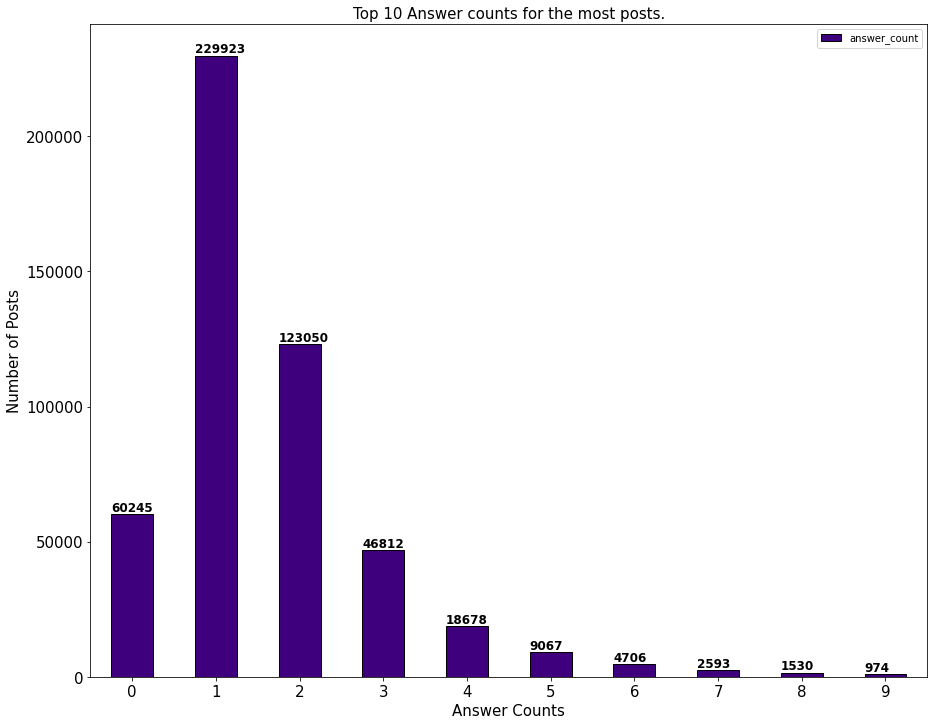

In [7]:
fig, ax = plt.subplots(figsize=(15, 12))

ans_plot=posts_answer_counts[:10].sort_index(ascending=True).plot.bar(x='answer_count',
                      ax=ax,fontsize=15,cmap="Purples_r" ,edgecolor="black")

ax.set_title("Top 10 Answer counts for the most posts.",size=15)
ax.legend().remove()
plt.xlabel("Answer Counts",size=15)
plt.ylabel("Number of Posts",size=15)

for i in ans_plot.patches:
  ans_plot.text(i.get_x(), i.get_height(),str((i.get_height())), fontsize=12,color='black',ha="left",va="bottom",weight="bold") 
  plt.legend(loc="upper right",fontsize=10)

plt.xticks(rotation=360)
plt.show()

In [8]:
posts_wo_answer=posts_answer_counts[0]

print("The",(posts_wo_answer/500000)*100,"% posts have no answers on the StackOverflow.")

The 12.049 % posts have no answers on the StackOverflow.


**_We observe that 12.049% posts on the StackOverflow are unanswered._**

----

In [9]:
stack_ex_clean_data['creation_date'] = pd.to_datetime(stack_ex_clean_data['creation_date']) #converting created_at column to datetime

In [10]:
#Craeting hour, date(full date), only date value, only month value, only year value columns for futhere analysis.
stack_ex_clean_data['creation_hour'] = stack_ex_clean_data['creation_date'].dt.hour #creating hour
stack_ex_clean_data['create_date_sh'] = stack_ex_clean_data['creation_date'].dt.date
stack_ex_clean_data['only_date'] = stack_ex_clean_data['creation_date'].apply(lambda x : str(x)[8:10])
stack_ex_clean_data['only_month'] = stack_ex_clean_data['creation_date'].apply(lambda x : str(x)[5:7])
stack_ex_clean_data["only_year"] = stack_ex_clean_data["creation_date"].apply(lambda x: str(x)[0:4])

In [11]:
aggdf = stack_ex_clean_data.reset_index().groupby(by=['only_month', 'only_date']).agg({'answer_count':'mean'}).reset_index().rename(columns={'answer_count':'mean_answer_count'})
aggdf['month_date'] = stack_ex_clean_data["create_date_sh"]

trace1 = go.Scatter(x = aggdf.month_date,
                    y = aggdf.mean_answer_count,
                    mode = "markers",
                    name = "citations",
                    marker = dict(color = 'rgba(16, 112, 2, 0.8)'),
                    )
data = [trace1]
layout = dict(title = 'How answer counts varied over time',
              xaxis= dict(title= 'Year',ticklen= 5,zeroline= False)
             )
fig = dict(data = data, layout = layout)
iplot(fig)

**_We observe that the 2009 has most question answered with a cluster of mean values for answer count on daily basis. From 2010 till 2016, we witness the answers were not posted on daily basis and have a scatter plot of answering counts with a wide spread._**

-----

**_Plotting how answer counts varies with time._**

In [12]:
trace1 = go.Scatter(x = stack_ex_clean_data["creation_hour"],
                    y = stack_ex_clean_data["creation_hour"].value_counts(),
                    mode = "markers",
                    marker = dict(color = 'rgba(9, 20, 20, 10)'),
                    )
data = [trace1]
layout = dict(title = 'What hour of the day people posts on StackOverflow',
              xaxis= dict(title= 'Hour',ticklen= 1,zeroline= False),
              yaxis=dict(title="Post Count")
             )
fig = dict(data = data, layout = layout)
iplot(fig)

**_we observe that people ask questions on StackOverlow throughout the day, around 0200 we have most questions posted and then at 2000 hours we have nearly 30K posts._**

------------

**_Removing the hyperlinks and tags as well_**

In [13]:
stack_ex_clean_data["body"] = stack_ex_clean_data["body"].str.replace("<.*?>", " ")
stack_ex_clean_data["body"] = stack_ex_clean_data["body"].str.replace(r'https?://[^\s<>"]+|www\.[^\s<>"]+', "")

**_changing the case of the words in the tags column_**

In [14]:
# stop_words = set(stopwords.words("english"))
stack_ex_clean_tags = ' '.join(stack_ex_clean_data['tags'].str.lower())

**_Printing Word cloud of the tags_**

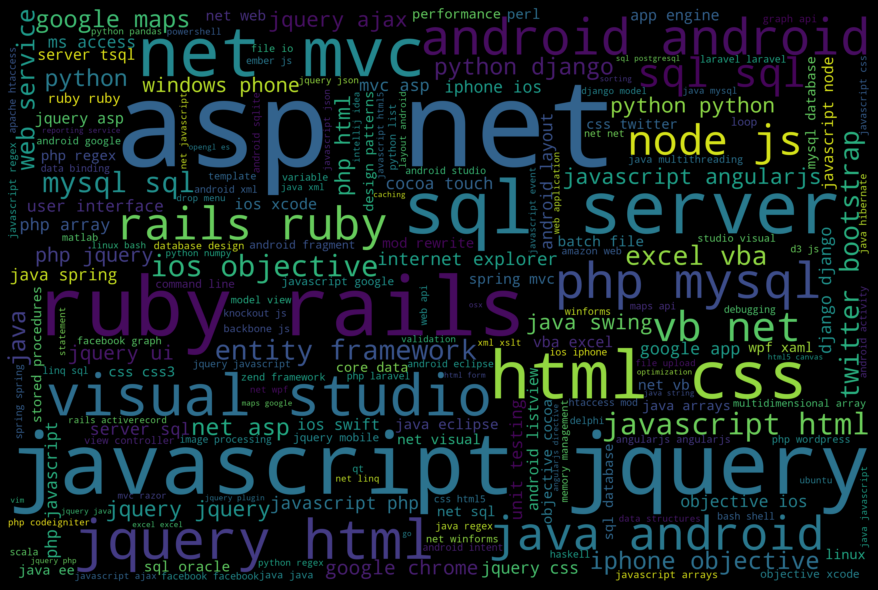

In [15]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    stopwords = STOPWORDS).generate(stack_ex_clean_tags)
fig = plt.figure(
    figsize = (12, 12),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

**_Making label column as per requirement for input to the fasttext module._**

In [16]:
stack_ex_clean_data["tags"] = [item.replace("|", " __label__") for item in stack_ex_clean_data["tags"]]
stack_ex_clean_data['tags'] ='__label__' + stack_ex_clean_data['tags'].astype(str)

In [17]:
stack_ex_clean_data[["tags","body"]].head()

,tags,body
0,__label__android __label__url __label__android...,I want my intent to be launched when the user...
1,__label__java __label__eclipse,I used to see both Building and Cleaning acti...
2,__label__winforms __label__deployment __label_...,Our team develops distributed winform apps. W...
3,__label__ios4 __label__uikit,In an iOS app I need to provide image filters...
4,__label__c# __label__delegates __label__action,I see this line in many online examples of us...
